#Visualise training

In [1]:
import sys
sys.path.append('../models/attention/')

import matplotlib.pyplot as plt
import cPickle as pkl
import seaborn
from collections import OrderedDict

models_dir = '/media/Data/flipvanrijn/models/'
models = OrderedDict()
models['W2V & TF-IDF'] = 'context_att_w2vtfidf.npz.pkl'
models['TF-IDF']   = 'context_att_tfidf.npz.pkl'
models['W2V n=1']  = 'context_att3.npz.pkl'
models['W2V n=3']  = 'context_att2.npz.pkl'

errors_val = []
errors_test = []

for model in models.values():
    with open('{}{}'.format(models_dir, model)) as f:
        opts = pkl.load(f)
    monitor = opts['monitor']
    errors_val.append([x[0] for x in monitor.history_errors])
    errors_test.append([x[1] for x in monitor.history_errors])

In [11]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure()
# Validation errors
for errors in errors_val:
    plt.plot(errors)
plt.legend(models.keys())
plt.xlabel('Epochs')
plt.ylabel('Log loss')
plt.title('Validation log loss')
plt.savefig('/home/flipvanrijn/plots/log-loss-val.pdf', dpi=1000)

fig = plt.figure()
# Test errors
for errors in errors_test:
    plt.plot(errors)
plt.legend(models.keys())
plt.xlabel('Epochs')
plt.ylabel('Log loss')
plt.title('Test log loss')
plt.savefig('/home/flipvanrijn/plots/log-loss-test.pdf', dpi=1000)

#Visualise model

In [39]:
import re
import numpy as np
base_path = '/media/Data/flipvanrijn/datasets/coco/processed/reduced/'

In [83]:
featdict = OrderedDict()
idx = 0
#with open(base_path+'train2014list.txt', 'r') as f: #    ls train > train2014list.txt
#    for line in f:
#        line = re.sub(r'\/.*\/','',line).strip()
#        featdict[line] = idx
#        idx += 1
with open(base_path+'val2014list.txt', 'r') as f: #    ls val > val2014list.txt
    for line in f:
        line = re.sub(r'\/.*\/','',line).strip()
        featdict[line] = idx
        idx += 1
split = []
with open(base_path+'splits/coco_val.txt', 'r') as f:
    for idx, line in enumerate(f):
        split.append(line.strip())

In [94]:
# load data
with open(base_path+'coco_align.dev.pkl', 'r') as f:
    data_cap = pkl.load(f)
    data_img = pkl.load(f)
    data_ctx = pkl.load(f)
    #data_raw = pkl.load(f)

In [5]:
from PIL import Image
import random

import matplotlib.pyplot as plt
plt.imshow(data_img[index].todense().reshape((196, 512)))
plt.show()

Index 3504
Image COCO_val2014_000000579673.jpg


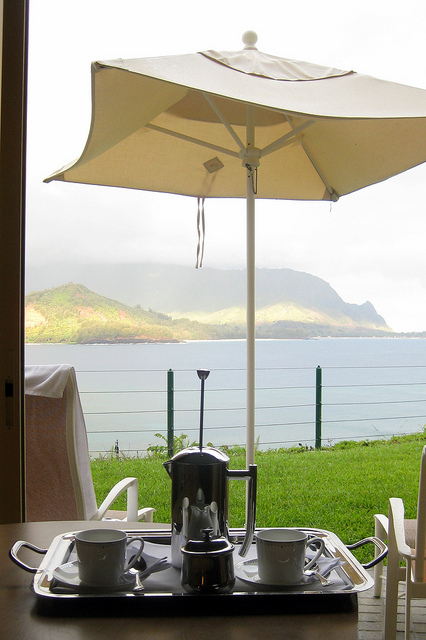

In [96]:
index = random.randint(0, len(split))
print 'Index', index
image_file = split[index]
print 'Image', image_file
image_path = '/media/Data/flipvanrijn/datasets/coco/images/val/'+image_file
img = Image.open(image_path)
#print data_raw[index]
img

In [12]:
#print 'Caption', data_cap[index]
server_data = {
    'pixels': img.tobytes(), 
    'size': img.size, 
    'mode': img.mode, 
    'introspect': True, 
    'file_path': image_path,
    'text_context': np.array(data_ctx[index].todense().reshape((150, 512))),
}
server_data = pkl.dumps(server_data)

In [13]:
import socket, struct
HOST, PORT = "localhost", 9999
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
try:
    # Connect to server and send data
    sock.connect((HOST, PORT))
    server_data = struct.pack('>I', len(server_data)) + server_data
    sock.sendall(server_data)

    # Receive data from the server and shut down
    received = sock.recv(1024)
    print received
finally:
    sock.close()

In [25]:
from gensim.models import Word2Vec
model = Word2Vec.load_word2vec_format('/media/Data/flipvanrijn/models/word2vec/enwiki-latest-pages.512.bin', binary=True)

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Quadro K2200


In [26]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
from itertools import islice
stop = stopwords.words('english')
stemmer = SnowballStemmer('english')
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) < n:
        yield result
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def preprocess(s, model):
    global stop, stemmer
    
    ns = []
    for w in s:
        if w and w in model and w not in stop:
            w = stemmer.stem(w)
            ns.append(w)

    return ns

In [51]:
c = []
context = data_raw[index]
c.append(preprocess(context[0].split(' '), model))
for desc in sent_tokenize(context[1]):
    desc = preprocess(desc.split(' '), model)
    if desc:
        c.append(desc)
tags = preprocess(context[2], model)
if tags:
    c.append(tags)
X = []
for sent in c:
    X += [' '.join(x) for x in window(sent, 2)]
X

[u'night surf', u'surf boyz']

In [69]:
stemmer.stem('cats')

u'cat'

# Visualize TF-IDF

In [56]:
import time
from colored import fg, bg

# load TFIDF model
print 'Loading TF-IDF model...'
t_tfidf_start = time.time()
with open('/media/Data/flipvanrijn/datasets/coco/processed/reduced/tfidf_model.pkl') as f_in:
    tfidf_model = pkl.load(f_in)
tfidf_feature_names = tfidf_model.get_feature_names()
print 'Loaded in {}s'.format(time.time() - t_tfidf_start)

# Load stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

Loading TF-IDF model...
Loaded in 3.10414004326s


In [66]:
def get_context(inpt):
    ''' 
    Stems the input and returns the context + raw version. 
    Expects: inpt -> string of tokens
    '''
    def preprocess(sentence):
        global stop, stemmer
        
        ns = []
        raw = []
        for word in sentence:
            if word:
                stemmed = stemmer.stem(word)
                ns.append(stemmed)
                raw.append(word)

        return ns, raw

    return preprocess(inpt.split(' '))

def tfidf_transform(context, context_raw, n_best=150):
    global tfidf_model, tfidf_feature_names
    '''
    Outputs a TF-IDF score for each word in the input.
    Expects: inpt -> string of tokens
    '''
    # Get TF-IDF count for current context
    feats = tfidf_model.transform([' '.join(context)]).todense()[0].tolist()[0]
    # Sort on score and grab best n_best
    scores = sorted(
        [(tfidf_feature_names[pair[0]], pair[1]) for pair in zip(range(0, len(feats)), feats) if pair[1] > 0], 
        key=lambda x: x[1] * -1
    )[:n_best]
    
    # extract relevant raw
    tfidf_dict = dict(scores)
    output = []
    for stemmed, raw in zip(context, context_raw):
        if stemmed in tfidf_dict.keys():
            output.append((raw, tfidf_dict[stemmed]))
        else:
            output.append((raw, 0))

    return output

def viz_tfidf(inpt):
    ''' 
    Prints a colored string of the raw context and their TF-IDF weights.
    Expects: inpt -> list of tuples [(word, score)]
    '''
    colors = range(232, 255, 1)[::-1] # Color range from dark to light
    scores = [s[1] for s in data] # TF-IDF scores
    words = [s[0] for s in data] # Words
    bins = np.linspace(0, 1, len(colors)) # Bins for the range 0 to 1 
    pos = np.digitize(scores, bins) # The index of the bin for each score/word
    for w, p, s in zip(words, pos, scores):
        if s > 0:
            print('%s%s%s' % (fg(255), bg(colors[p]-10), w)),
        else:
            print('%s%s%s' % (fg('black'), bg(255), w)), # stopword/unknown word

In [45]:
print 'Loading context data...'
with open('/media/Data/flipvanrijn/datasets/coco/processed/reduced/coco_val_context.pkl', 'r') as f:
    titles = pkl.load(f)
    descriptions = pkl.load(f)
    tags = pkl.load(f)
print 'Done'

Loading context data...
Done


In [102]:
inpt = 'luang prabang 199 this dog loved to sack out on the shoe rack at villa merry no . 1 . laos lao vacation travel trip luangprabang dog shoes cute'
inpt = ''

print tags[featdict[split[index]]]
context, raw = get_context(inpt)
data = tfidf_transform(context, raw)

[u'lanai', u'stregisprinceville', u'hotel', u'stregis', u'princeville', u'kauai', u'kauaicounty', u'hawaii', u'princejuniorsuite', u'coffee', u'cup', u'frenchpress', u'butlerservice', u'umbrella', u'hanaleibay', u'stregisbutlerservice', u'starwood', u'starwoodhotels', u'starwoodhotelsresorts']


In [70]:
viz_tfidf(data)

luang prabang 199 this dog loved to sack out on the shoe rack at villa merry no . 1 . laos lao vacation travel trip luangprabang dog shoes cute


In [79]:
[featdict[split[index]]

IndexError: list index out of range